# 0. 课程前言
此为《人工智能安全》实验课第二部分：对抗训练实验部分.

**对抗攻击的本质**

在上一章节中，我们学习了对抗攻击的核心原理：**对抗扰动攻击本质是一个有约束的优化问题**。攻击者试图在输入样本 $x$ 上添加微小扰动 $\delta$，使其在扰动范数约束 $||\delta|| \le \epsilon$ 下，最大化模型的损失函数：

$$
\delta^* = \arg \max _{||\delta|| \le \epsilon} \mathcal{L} (h_\theta(x + \delta), y)
$$

这意味着，攻击者的目标是找到使模型 $h_\theta$ 预测错误且扰动最小的对抗样本 $x + \delta$。

**对抗训练的目标**

本节课我们将学习如何训练一个对对抗攻击具有**鲁棒性**的模型。其核心思想是通过优化模型参数 $\theta$ ，使得即使输入被添加了最坏情况的扰动，模型仍能保持性能稳定。这一目标可形式化为一个**min-max**双层优化问题：

$$
\theta^* = \arg \min _\theta \left[ \frac{1}{|S|} \sum_{x, y \in S} \max_{||\delta|| \le \epsilon} \mathcal{L}(h_\theta(x + \delta), y) \right]
$$

+ 内层最大化（Max）：针对每个训练样本 $x$ ，寻找使损失最大的对抗扰动 $\delta^*$，模拟攻击者的行为。
+ 外层最小化（Min）：优化模型参数 $\theta$，使得在最坏扰动下，所有训练样本的平均损失最小化。

通过这种优化框架，模型在训练过程中不断暴露于“最困难”的对抗样本，从而学习到更强的鲁棒特征。与普通训练不同，对抗训练不仅要求模型在干净数据上表现良好，还需要在扰动数据上保持稳定性。

# 1. 训练准备

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# 使用 MNIST 数据集进行测试
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
# 定义数据迭代器实例
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)
# 选择 device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 设置 torch 种子，实现复现性
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

# 卷积神经网络
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

为提升模型的鲁棒性，我们尝试采用上节课学习到的 **快速梯度符号法(FGSM)** 和 **投影梯度下降法(PGD)** 算法来计算微小扰动，进而开展对抗训练。


In [3]:
# FGSM算法，返回扰动 delta
def fgsm(model, X, y, epsilon=0.1):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

# PGD算法，返回扰动 delta
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

# 2. 对抗训练

**如何进行对抗训练**

我们的目标是优化如下对抗训练函数：

$$
\theta^* = \arg \min _\theta \left[ \frac{1}{|S|} \sum_{x, y \in S} \max_{||\delta|| \le \epsilon} \mathcal{L}(h_\theta(x + \delta), y) \right]
$$

这与普通训练函数

$$
\theta = \arg \min _\theta \left[ \frac{1}{|S|} \sum_{x, y \in S} \mathcal{L}(h_\theta(x), y) \right]
$$

存在相似性，显然，我们能够在普通训练函数的基础上开展优化工作。

与普通训练函数的优化思路一致，我们考虑采用梯度下降方法。若要通过随机梯度下降简单地优化 $\theta$ ，就需要针对一些小批量数据，计算损失函数关于 $\theta$ 的梯度，然后朝着该梯度的负方向更新参数。具体而言，我们要重复更新

$$
\theta := \theta - \alpha \frac {1}{|B|} \sum_{x, y \in B} \nabla_\theta \max_{||\delta||\le \epsilon} \mathcal{L} (h_\theta(x+\delta), y)
$$

对于内层最大化函数的梯度计算，我们可以按以下两步进行：
1）找到使损失函数取得最大值的扰动 $\delta$。
2）计算该最大值点处的正常梯度。相关梯度由以下给出：

$$
\begin{align}
&\delta^*(x) = \arg \max \mathcal{L}(h_\theta(x+\delta), y) \notag \\

&\nabla_\theta \max_{||\delta|| \le \epsilon} \mathcal{L}(h_\theta(x+\delta), y) = \nabla_\theta \mathcal{L}(h_\theta(x+\delta^*(x)), y) \notag \\
\end{align}
$$

我们可以使用如下伪代码来表示对抗训练的过程：

对于每个 $epoch$ :

1. 选择一个$batch$, 初始化梯度向量为 $0 $

2. 对于样本 $(x, y) \in batch$

    +  使用对抗攻击算法求出最大扰动 $\delta^*$

        $\delta^*(x) = \arg \max \mathcal{L}(h_\theta(x+\delta), y)$
    
    + 计算 $x + \delta^*$ 处的梯度

        $g := g + \nabla_\theta \mathcal{L}(h_\theta(x+\delta^*), y)$

3. 更新模型参数

    $\theta := \theta - \frac {\alpha}{|B|} g$

实际上，后续的参数更新步骤可借助模型的反向传播机制直接完成，这里仅对对抗训练的基本原理进行阐述。

In [5]:
# 返回模型在干净数据集上一个 epoch 的训练/测试误差
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt: # optimizer: Training  None: Evaluation
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    # 返回误差/损失
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


# 返回模型在对抗数据集上一个 epoch 的训练/测试误差
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt: # optimizer: Training  None: Evaluation
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

接下来，让我们测试普通训练的模型的表现：

In [6]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
print("Train Error", "Test Error", "Adv Error", sep="\t")

# 模型在 MNIST 上进行训练
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

Train Error	Test Error	Adv Error
0.280867	0.030100	0.625900
0.026583	0.019200	0.650100
0.017417	0.015400	0.653200
0.013067	0.015500	0.684900
0.009683	0.013600	0.744300
0.004033	0.011300	0.712000
0.002750	0.011600	0.719000
0.002583	0.011400	0.718400
0.002183	0.011400	0.720200
0.002033	0.010900	0.729400


干净模型测试集上，模型错误率为 $1\%$，而在对抗样本测试集上，模型错误率为 $72\%$。
这与上一节的结论一致，普通模型对干净数据表现良好，但对微小对抗扰动极度脆弱，这表明模型依赖的**非鲁棒特征**易被攻击者利用。

接下来，我们采用**PGD对抗训练**（$\alpha=0.01, \epsilon=0.1$）重新训练模型，并在相同数据集上评估：

In [7]:
# 定义使用对抗性训练的模型
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [8]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
print("Train Error", "Test Error", "Adv Error", sep="\t")
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

Train Error	Test Error	Adv Error
0.690700	0.103800	0.223200
0.094633	0.018400	0.055200
0.051200	0.015000	0.043800
0.038267	0.015500	0.042600
0.031733	0.012000	0.033300
0.021333	0.009000	0.028300
0.019633	0.009000	0.029400
0.019133	0.008600	0.028300
0.018267	0.009000	0.027600
0.017917	0.008800	0.027800


进行对抗训练后，模型的对抗样本错误率大幅下降，这说明模型学会了抵抗预设攻击强度的扰动。同时，模型在干净样本错误率几乎保持不变，这说明对抗训练没有破坏模型对原始任务的理解，其学到的是**本质鲁棒特征**。

In [9]:
# 返回模型在不同对抗攻击算法下的误差
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, 
                                             num_iter=40, randomize=True)[0])

FGSM:  0.026
PGD, 40 iter:  0.0279
PGD, small_alpha:  0.0278
PGD, randomized:  0.0279


# 3. 绘制损失函数图像

所以为什么对抗训练得到的模型拥有更好的鲁棒性呢？这个问题有很多种理论回答。但我们可以通过绘出普通模型与对抗训练模型的 loss 曲面图来观察一下它们之间的差异。以下代码将损失函数投影至输入空间的两个维度： x 轴代表随机方向， y 轴代表梯度方向。

In [10]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [ ]:
def draw_loss(model, X, epsilon):
    # 使用 meshgrid 创建网格数据
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    # 该函数用于计算扰动为 delta 时的梯度方向，使用 sign 函数来获取每一维上的方向
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    # dir1 为 loss 函数的梯度方向
    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    # dir2 为随机方向
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    # 矩阵乘法，得到每个 (x,y) 对应的扰动下的输入。其中 x 轴坐标代表沿随机方向的扰动大小，y 轴坐标代表沿 loss 函数的梯度方向的扰动大小
    # 矩阵乘法保证每个 Xi 中的每个元素与 dir2 （随机方向）中对应的元素相乘，每个 Yi 中的每个元素与 dir1 （loss 函数的梯度方向）中对应的元素相乘
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    # 得到不同扰动下的 loss 值，对应 (x,y) 处的 z 坐标
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    # 使用 add_subplot 创建 3D 坐标轴
    ax = fig.add_subplot(111, projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

下面绘制正常训练所得模型的 loss 曲面。

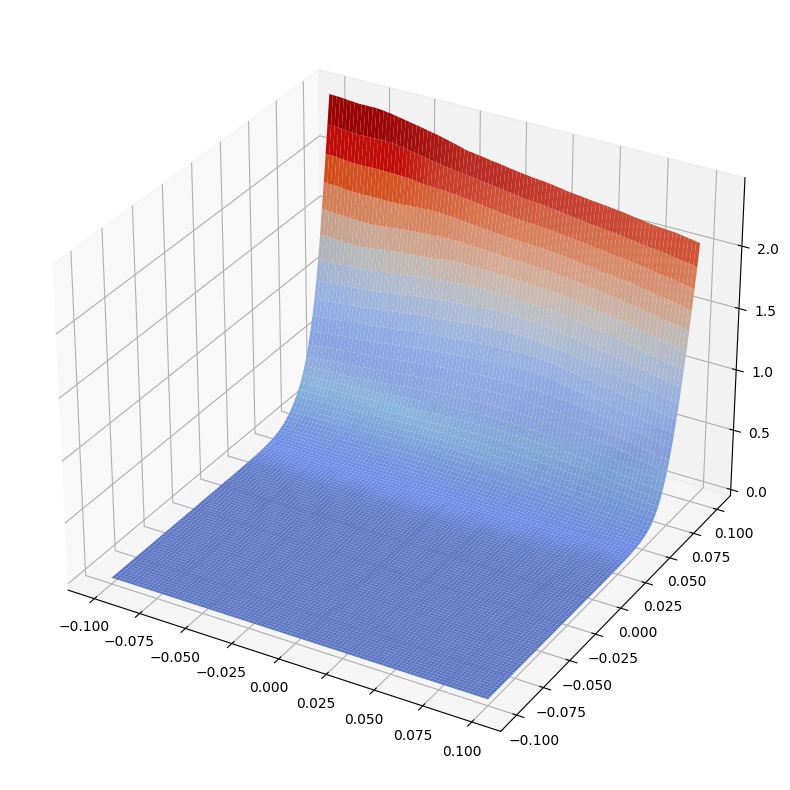

In [12]:
draw_loss(model_cnn, X[0:1], 0.1)

如上文所述，该曲面中的每一点 $(x,y,z)$ 中的 $x$ 坐标的值代表沿随机方向的扰动大小， $y$ 坐标的值代表沿**梯度方向**的扰动大小， $z$ 坐标则代表损失函数在该 $(x,y)$ 扰动下的值。即

令 $\pmb{\lambda}$ 为随机方向的向量（各维度上的值均为 $1,0,-1$ ），代表其在该维度上的“方向”）， $\pmb{\mu}$ 为损失函数**梯度方向**的向量。则每一个点 $(x,y)$ 对应的 $z$ 值为
$$
z(x,y)=\mathcal{L}(h_\theta(\pmb{X}+x\pmb{\lambda}+y\pmb{\mu}), y)
$$
其中 $\pmb{X}$ 代表原始输入图像， $y$ 代表真实标签， $h_\theta$ 代表模型。

可以从图像看出，正常训练所得模型的 loss 曲面沿 $y$ 轴方向十分“陡峭”，损失函数值变化非常剧烈，说明损失函数沿**梯度方向**下降/上升的非常快。这是正常模型得到的 loss 曲面。下面绘制对抗训练所得模型的 loss 曲面图。

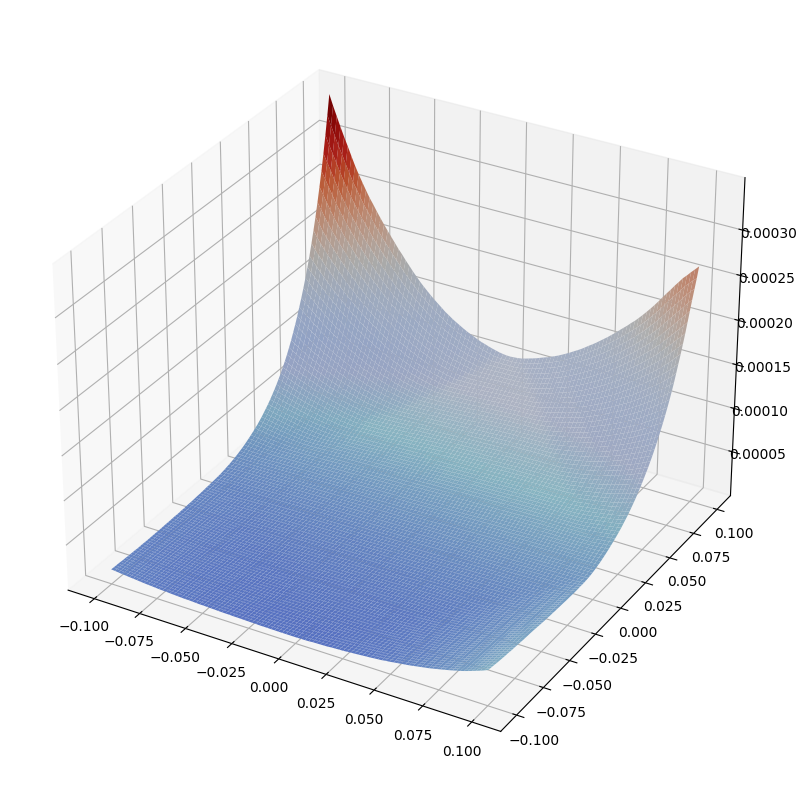

In [ ]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

乍一看这个对抗训练所得模型的 loss 曲线似乎和上面的差不多。但仔细看看 $z$ 轴的值，会发现其相较于上张图小了很多。（如果放在同一比例尺下第二个曲面会变得非常**平坦**。）对抗训练所得模型的 loss 曲面非常**平坦**，无论是在随机方向上还是梯度方向上。而与之相对的，正常训练所得模型的 loss 值在梯度方向上变化非常大，在沿梯度方向“前进”了一段距离后的随机方向上 loss 值变化也较为明显。

总的来说，对抗训练所得模型在实际应用中拥有较高的对抗鲁棒性，并且其拥有一个非常平坦的 loss 曲面。更多关于鲁棒性的原因机制还需未来的更进一步的研究来说明。

# 4. 基于松弛的对抗训练
为了实现对 `model_cnn_robust` 鲁棒性能的量化评估，下面将借助这套测试模型鲁棒性的代码，对该模型在测试数据集上的鲁棒性展开系统性测试 。

In [22]:
'''
bound_propagation 函数:
    计算神经网络各层的输出区间边界, 遍历模型每一层, 对于不同的层类型(Flatten、nn.Linear、nn.Conv2d、nn.RELU)
    使用对应公式计算其输出的上下界, 存储在 bounds 中
'''
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

'''
interval_based_bound 函数:
    基于模型输出边界(bounds)计算神经网络模型的鲁棒性下界.
'''
def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()    

'''
epoch_robust_bound 函数:
    计算模型在一个 epoch 内的鲁棒性误差
    返回测试集上模型的鲁棒性误差比例, 即, 统计在给定 epsilon 扰动范围内, 模型在各个类别上
    不满足鲁棒性条件的样本数量占总样本数量的比例.
'''
def evaluate_epoch_robust_bound(loader, model, epsilon):
    total_err = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

In [23]:
evaluate_epoch_robust_bound(test_loader, model_cnn_robust, 0.1)

1.0

In [24]:
evaluate_epoch_robust_bound(test_loader, model_cnn_robust, 0.0001)

0.0203

通过对上述代码的运行与分析可得，当扰动参数 $\epsilon \in [-0.1, 0.1]$ 时，模型 `model_cnn_robust` 无法展现出鲁棒特性（几乎所有测试集样本均不满足模型鲁棒性条件）；当扰动参数 $\epsilon$ 收缩至 $[-0.0001, 0.0001]$时，模型的鲁棒性显著提升，测试集中约 $98\%$ 的样本满足鲁棒性要求。

换句话说，我们的模型在 $||\epsilon||_\infty \le 0.0001$ 时具有良好的鲁棒性。

下面，我们将借助模型鲁棒性评估的结果，对模型训练过程实施优化。在训练或评估的每个批次中，先依据输入数据和指定的扰动范围，计算模型各层输出的区间边界。
在此基础上，针对模型预测的类别，计算该类别下的鲁棒性下界，将这个下界累加到损失函数值 `loss` 中。

这样，损失函数不仅包括了常规的分类错误，还融入了模型在面对输入扰动时的鲁棒性信息，模型根据这个损失函数更新参数，从而在模型分类准确率提升的同时，
促使模型在指定扰动范围内的鲁棒性得到增强，应对输入数据可能存在的各种干扰。

In [ ]:
def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]  
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [18]:
torch.manual_seed(0)
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [19]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)

    # 调参使用
    if t == 4:
       for param_group in opt.param_groups:
           param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

Train Eps	Train Loss*	Test Err	Test Robust Err


0.000000	0.835771	0.031500	1.000000
0.000100	0.125941	0.021500	1.000000
0.001000	0.120870	0.022600	1.000000
0.010000	0.341352	0.028100	1.000000
0.010000	0.160670	0.025400	1.000000
0.050000	0.560360	0.030000	0.975400
0.050000	0.427368	0.030300	0.963600
0.050000	0.384079	0.030600	0.930500
0.050000	0.357235	0.030200	0.886300
0.050000	0.337236	0.030800	0.830700
0.100000	0.838830	0.041600	0.185400
0.100000	0.637333	0.043000	0.164000
0.100000	0.562028	0.042400	0.147400
0.100000	0.515194	0.040700	0.135600
0.100000	0.475985	0.041400	0.127500
0.100000	0.441126	0.040900	0.120200
0.100000	0.412448	0.040300	0.112500
0.100000	0.389139	0.040600	0.108200
0.100000	0.368990	0.038800	0.103100
0.100000	0.352168	0.039200	0.101400
0.100000	0.338744	0.038700	0.097300
0.100000	0.326916	0.038000	0.094100
0.100000	0.316879	0.037100	0.092000
0.100000	0.308328	0.037400	0.088800
0.100000	0.300363	0.037500	0.089300


In [20]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.0689


In [26]:
evaluate_epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)

0.0893